In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
mnist = tf.keras.datasets.mnist

In [2]:
def leakyReLU(x, alpha):
    return tf.maximum(alpha*x, x)

In [3]:
class Dataset:
    def __init__(self, train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=True):
        self.train_img = train_images
        self.train_labels = train_labels
        self.shuffle = shuffle
        self.projection_data_path = projection_data_path
        self.metadata_tsv = '%s/metadata.tsv' % projection_data_path
        self.sprite = '%s/sprite_train_img.png' % projection_data_path
        if self.shuffle:
            idx = np.arange(len(self.train_img))
            np.random.shuffle(idx)
            self.train_img = self.train_img[idx]
            self.train_labels = self.train_labels[idx]
        
        whole_train = len(train_images)
        num_validation_samples = int(whole_train*validation)
        num_train_sample = whole_train - num_validation_samples
        
        self.train_img = self.train_img[:num_train_sample,:,:]
        self.train_img = self.prepare_data(self.train_img)
        self.train_labels = self.train_labels[:num_train_sample]
        
        self.test_img = self.prepare_data(test_images)
        self.test_labels = test_labels
        
        if not validation == 0.0:
            self.validation_labels = self.train_labels[num_train_sample+1:]
            self.validation_img = self.train_img[num_train_sample+1:,:,:]
            self.validation_img = self.prepare_data(self.validation_img)        
            if len(self.train_img.shape)==3:
                new_shape = self.validation_img.shape + (1,)
                self.validation_img = self.validation_img.reshape(new_shape)

        
        if len(self.train_img.shape)==3:
            new_shape = self.train_img.shape + (1,)
            self.train_img = self.train_img.reshape(new_shape)
            new_shape = self.test_img.shape + (1,)
            self.test_img = self.test_img.reshape(new_shape)
        
        self.data_shape = self.train_img.shape
        
    def normalize(self, images):
        # Normalize.
        max_value = np.amax(images)
        post = images/max_value
        return post
    
    # Function to pre-process the data.
    def prepare_data(self, images):
        post_images = self.normalize(images)
        return post_images
    
    def batches(self, batch_size):
        n_batches = self.train_img.shape[0]//batch_size
        for index in range(0, n_batches):
            x = self.train_img[index:index+batch_size, :, :, :]
            y = self.train_labels[index:index+batch_size]
            yield (x, y)

    def random_test(self):
        idx = np.arange(len(self.test_img))
        np.random.shuffle(idx)
        return [self.test_img[idx[0], :, :]]
    
    def random_train(self):
        idx = np.arange(len(self.train_img))
        np.random.shuffle(idx)
        return [self.train_img[idx[0], :, :]]
    
    def create_sprite_image(self, images):
        if os.path.isfile(self.sprite):
            os.remove(self.sprite)

        img_h = images.shape[1]
        img_w = images.shape[2]
        n_plots = int(np.ceil(np.sqrt(images.shape[0])))
        spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
        for i in range(n_plots):
            for j in range(n_plots):
                this_filter = i * n_plots + j
                if this_filter < images.shape[0]:
                    this_img = images[this_filter]
                    spriteimage[i * img_h:(i + 1) * img_h, j * img_w:(j + 1) * img_w] = this_img
        plt.imsave(self.sprite, spriteimage,cmap='gray')

    def create_tsv_file(self, img_labels):
        if os.path.isfile(self.metadata_tsv):
            os.remove(self.metadata_tsv)
        
        with open(self.metadata_tsv,'w') as f:
            f.write("Index\tLabel\n")
            for index,label in enumerate(img_labels):
                f.write("%d\t%d\n" % (index,label))

In [4]:
# Simple function to plot number images.
def plot_images(plt_num, images, dim, cmap):
    # Standard parameters for the plot.
    
    mpl.rcParams["figure.figsize"] = dim, dim
    fig = plt.figure()
    for i in range(0, plt_num):
        fig.add_subplot(1, 10, i+1)
        img = images[i, :, :, 0]
        plt.imshow(img, cmap=cmap)
    plt.show()

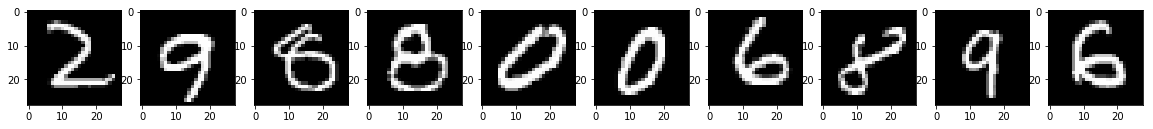

In [5]:
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()
projection_data_path = '/Users/adalbertoclaudioquiros/Documents/Code/UofG/PhD/GANs'
data = Dataset(train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=True)

plot_images(plt_num=10, images=data.train_img, dim=20, cmap='gray')

In [6]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    real_images = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name='real_images')
    z_input = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    return real_images, z_input, learning_rate

In [7]:
def discriminator(images, reuse, alpha):
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input Shape: (None, 28, 28, 1)
        # Padding = 'Same' -> H_new = H_old // Stride
        
        # Conv layer.
        net = tf.layers.conv2d(inputs=images, filters=64, kernel_size=(5,5), strides=(2, 2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        net = leakyReLU(net, alpha)
        # Shape: (None, 16, 16, 64)
        
        # Conv layer.
        net = tf.layers.conv2d(inputs=net, filters=128, kernel_size=(5,5), strides=(2, 2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        net = tf.layers.batch_normalization(net, training=True)
        net = leakyReLU(net, alpha)
        # Shape: (None, 8, 8, 128)

        net = tf.layers.flatten(net, name='flatten')
        # Shape: (None, 8*8*128)

        # Dense.
        net = tf.layers.dense(net, 1024, activation=None)
        net = tf.layers.batch_normalization(net, training=True)
        net = leakyReLU(net, alpha)
        # Shape: (None, 1024)
        
        # Dense.
        logits = tf.layers.dense(net, 1, activation=None)
        # Shape: (None, 1)
        output = tf.nn.sigmoid(logits)
        
        return output, logits

In [8]:
def generator(z_input, out_channel_dim, reuse, is_train, alpha):
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # Dense layer.
        net = tf.layers.dense(inputs=z_input, units=1024, activation=None)
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape: (None, 1024)
        
        # Dense layer.
        net = tf.layers.dense(inputs=net, units=128*7*7, activation=None)
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape: (None, 128*7*7)
        
        net = tf.reshape(net, (-1, 7, 7, 128))
        # Shape: (None, 7, 7, 128)
        
        # Conv
        net = tf.layers.conv2d_transpose(inputs=net, filters=128, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape: (None, 14, 14, 128)
        
        # Conv
        net = tf.layers.conv2d_transpose(inputs=net, filters=128, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape: (None, 14, 14, 128)
        
        # Conv
        logits = tf.layers.conv2d_transpose(inputs=net, filters=out_channel_dim, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # Shape: (None, 28, 28, 1)
        output = tf.nn.sigmoid(logits)
        
        return output

In [9]:
def show_generated(session, output_fake, n_images, z_input, image_type):
    cmap = None if image_type == 'RGB' else 'gray'
    z_dim = z_input.get_shape()[-1]
    sample_z = np.random.uniform(low=-1., high=1., size=(n_images, z_dim))
    feed_dict = {z_input:sample_z}
    gen_samples = session.run(output_fake, feed_dict=feed_dict)
    
    gen_samples *= 255.
    
    plot_images(plt_num=n_images, images=gen_samples, dim=10, cmap=cmap)    

In [10]:
def loss(real_images, z_input, out_channel_dim, alpha):
    
    # Generator.
    fake_images = generator(z_input, out_channel_dim=out_channel_dim, reuse=False, is_train=True, alpha=alpha)
    
    # Discriminator.
    output_fake, logits_fake = discriminator(images=fake_images, reuse=False, alpha=alpha) 
    output_real, logits_real = discriminator(images=real_images, reuse=True, alpha=alpha)
    
    # Discriminator loss.
    loss_dis_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.zeros_like(output_fake)))
    loss_dis_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(output_fake)*0.9))
    loss_dis = loss_dis_fake + loss_dis_real

    # Generator loss.
    # This is where we implement -log[D(G(z))] instead log[1-D(G(z))].
    # Recall the implementation of cross-entropy, sign already in. 
    loss_gen = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.ones_like(output_fake)))
    
    return loss_dis, loss_gen

In [11]:
def optimization(loss_dis, loss_gen, learning_rate, beta1):
    trainable_variables = tf.trainable_variables()
    generator_variables = [variable for variable in trainable_variables if variable.name.startswith('generator')]
    discriminator_variables = [variable for variable in trainable_variables if variable.name.startswith('discriminator')]
    
    # Handling Batch Normalization.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        train_generator = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                                 beta1=beta1).minimize(loss_gen, var_list=generator_variables)
        train_discriminator = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                                     beta1=beta1).minimize(loss_dis, var_list=discriminator_variables)    
    return train_generator, train_discriminator

In [12]:
def train(epochs, batch_size, z_dim, learning_rate, beta1, dataset, image_type, alpha):
    
    dataset_size, image_width, image_height, image_channels = dataset.data_shape
    
    real_images, z_input, learning_rate_input = model_inputs(image_width=image_width, image_height=image_height, 
                                                            image_channels=image_channels, z_dim=z_dim)
    loss_dis, loss_gen = loss(real_images=real_images, z_input=z_input, out_channel_dim=image_channels, alpha=alpha)
    train_generator, train_discriminator = optimization(loss_dis=loss_dis, loss_gen=loss_gen, learning_rate=learning_rate_input, 
                                                       beta1=beta1)
    
    output_gen = generator(z_input=z_input, out_channel_dim=image_channels, reuse=True, is_train=False, alpha=alpha)

    samples = list()
    losses = list()
    run_epochs = 0
    
    show_epochs = 100
    print_epochs = 10
    n_images = 10
    
    images_e = 0
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        for epoch in range(epochs+1):
            get_batches = data.batches(batch_size)
            for batch_images, batch_labels in get_batches.__iter__():
                images_e += batch_images.shape[0]
                z_batch = np.random.uniform(low=-1., high=1., size=(batch_size, z_dim))
               
                feed_dict = {z_input:z_batch, real_images:batch_images, learning_rate_input: learning_rate}
                session.run(train_discriminator, feed_dict=feed_dict)
                session.run(train_generator, feed_dict=feed_dict)
               
                if run_epochs%print_epochs==0:
                    feed_dict = {z_input:z_batch, real_images:batch_images}
                    epoch_loss_dis = session.run(loss_dis, feed_dict=feed_dict)
                    epoch_loss_gen = session.run(loss_gen, feed_dict=feed_dict)
                    losses.append((epoch_loss_dis, epoch_loss_gen))
                    print('Epochs %s/%s: Generator Loss: %s. Discriminator Loss: %s' % (epoch, epochs, np.round(epoch_loss_gen, 3), 
                                                                                        np.round(epoch_loss_dis, 3)))
                if run_epochs%show_epochs == 0:
                    show_generated(session=session, output_fake=output_gen, n_images=n_images, z_input=z_input, 
                                   image_type=image_type)
                run_epochs+=1


Epochs 0/10: Generator Loss: 0.78. Discriminator Loss: 1.806


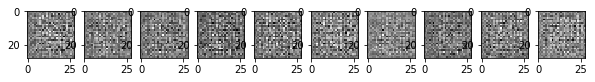

Epochs 0/10: Generator Loss: 0.739. Discriminator Loss: 1.13
Epochs 0/10: Generator Loss: 0.891. Discriminator Loss: 0.993
Epochs 0/10: Generator Loss: 0.99. Discriminator Loss: 0.94
Epochs 0/10: Generator Loss: 1.038. Discriminator Loss: 0.908
Epochs 0/10: Generator Loss: 1.13. Discriminator Loss: 0.895
Epochs 0/10: Generator Loss: 1.146. Discriminator Loss: 0.848
Epochs 0/10: Generator Loss: 1.165. Discriminator Loss: 0.824
Epochs 0/10: Generator Loss: 1.182. Discriminator Loss: 0.827
Epochs 0/10: Generator Loss: 1.198. Discriminator Loss: 0.808
Epochs 0/10: Generator Loss: 1.204. Discriminator Loss: 0.826


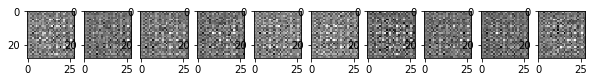

Epochs 0/10: Generator Loss: 1.188. Discriminator Loss: 0.861
Epochs 0/10: Generator Loss: 1.205. Discriminator Loss: 0.809
Epochs 0/10: Generator Loss: 1.249. Discriminator Loss: 0.794
Epochs 0/10: Generator Loss: 1.232. Discriminator Loss: 0.797
Epochs 0/10: Generator Loss: 1.266. Discriminator Loss: 0.786
Epochs 0/10: Generator Loss: 1.301. Discriminator Loss: 0.763
Epochs 0/10: Generator Loss: 1.3. Discriminator Loss: 0.804
Epochs 0/10: Generator Loss: 1.268. Discriminator Loss: 0.809
Epochs 0/10: Generator Loss: 1.307. Discriminator Loss: 0.79
Epochs 0/10: Generator Loss: 1.34. Discriminator Loss: 0.733


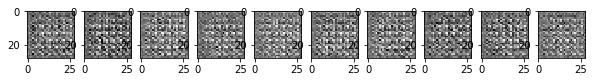

Epochs 0/10: Generator Loss: 1.355. Discriminator Loss: 0.768
Epochs 0/10: Generator Loss: 1.371. Discriminator Loss: 0.718
Epochs 0/10: Generator Loss: 1.379. Discriminator Loss: 0.705
Epochs 0/10: Generator Loss: 1.382. Discriminator Loss: 0.742
Epochs 0/10: Generator Loss: 1.391. Discriminator Loss: 0.717
Epochs 0/10: Generator Loss: 1.41. Discriminator Loss: 0.718
Epochs 0/10: Generator Loss: 1.417. Discriminator Loss: 0.705
Epochs 0/10: Generator Loss: 1.464. Discriminator Loss: 0.684
Epochs 0/10: Generator Loss: 1.46. Discriminator Loss: 0.682
Epochs 0/10: Generator Loss: 1.408. Discriminator Loss: 0.719


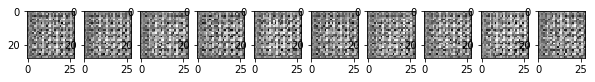

Epochs 0/10: Generator Loss: 1.434. Discriminator Loss: 0.697
Epochs 0/10: Generator Loss: 1.477. Discriminator Loss: 0.689
Epochs 0/10: Generator Loss: 1.47. Discriminator Loss: 0.685
Epochs 0/10: Generator Loss: 1.514. Discriminator Loss: 0.659
Epochs 0/10: Generator Loss: 1.512. Discriminator Loss: 0.675
Epochs 0/10: Generator Loss: 1.534. Discriminator Loss: 0.745
Epochs 0/10: Generator Loss: 1.458. Discriminator Loss: 0.686
Epochs 0/10: Generator Loss: 1.503. Discriminator Loss: 0.674
Epochs 0/10: Generator Loss: 1.515. Discriminator Loss: 0.662
Epochs 0/10: Generator Loss: 1.567. Discriminator Loss: 0.635


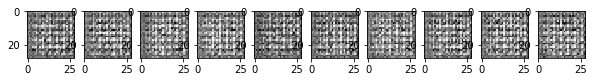

Epochs 0/10: Generator Loss: 1.577. Discriminator Loss: 0.67
Epochs 0/10: Generator Loss: 1.506. Discriminator Loss: 0.664
Epochs 0/10: Generator Loss: 1.56. Discriminator Loss: 0.637
Epochs 0/10: Generator Loss: 1.621. Discriminator Loss: 0.615
Epochs 0/10: Generator Loss: 1.64. Discriminator Loss: 0.611
Epochs 0/10: Generator Loss: 1.636. Discriminator Loss: 0.649
Epochs 0/10: Generator Loss: 1.58. Discriminator Loss: 0.644
Epochs 0/10: Generator Loss: 1.592. Discriminator Loss: 0.647
Epochs 0/10: Generator Loss: 1.586. Discriminator Loss: 0.686
Epochs 0/10: Generator Loss: 1.614. Discriminator Loss: 0.636


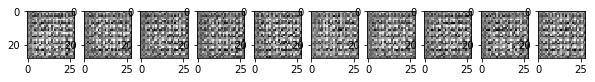

Epochs 0/10: Generator Loss: 1.664. Discriminator Loss: 0.618
Epochs 0/10: Generator Loss: 1.662. Discriminator Loss: 0.613
Epochs 0/10: Generator Loss: 1.636. Discriminator Loss: 0.628
Epochs 0/10: Generator Loss: 1.634. Discriminator Loss: 0.63
Epochs 0/10: Generator Loss: 1.654. Discriminator Loss: 0.635
Epochs 0/10: Generator Loss: 1.651. Discriminator Loss: 0.61
Epochs 0/10: Generator Loss: 1.74. Discriminator Loss: 0.604
Epochs 0/10: Generator Loss: 1.825. Discriminator Loss: 0.561
Epochs 0/10: Generator Loss: 1.831. Discriminator Loss: 1.448
Epochs 0/10: Generator Loss: 1.57. Discriminator Loss: 0.617


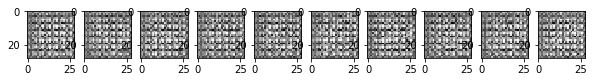

Epochs 0/10: Generator Loss: 1.592. Discriminator Loss: 0.659
Epochs 0/10: Generator Loss: 1.623. Discriminator Loss: 0.619
Epochs 0/10: Generator Loss: 1.607. Discriminator Loss: 0.653
Epochs 0/10: Generator Loss: 1.662. Discriminator Loss: 0.6
Epochs 0/10: Generator Loss: 1.635. Discriminator Loss: 0.633
Epochs 0/10: Generator Loss: 1.649. Discriminator Loss: 0.623
Epochs 0/10: Generator Loss: 1.73. Discriminator Loss: 0.579
Epochs 0/10: Generator Loss: 1.725. Discriminator Loss: 0.613
Epochs 0/10: Generator Loss: 1.795. Discriminator Loss: 0.571
Epochs 0/10: Generator Loss: 1.677. Discriminator Loss: 0.61


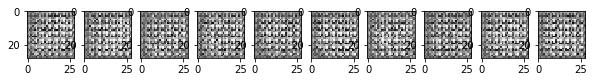

Epochs 0/10: Generator Loss: 1.771. Discriminator Loss: 0.569
Epochs 0/10: Generator Loss: 1.841. Discriminator Loss: 0.548
Epochs 0/10: Generator Loss: 1.918. Discriminator Loss: 0.54
Epochs 0/10: Generator Loss: 1.91. Discriminator Loss: 0.595
Epochs 0/10: Generator Loss: 1.847. Discriminator Loss: 0.554
Epochs 0/10: Generator Loss: 1.841. Discriminator Loss: 0.605
Epochs 0/10: Generator Loss: 1.862. Discriminator Loss: 0.546
Epochs 0/10: Generator Loss: 1.698. Discriminator Loss: 0.624
Epochs 0/10: Generator Loss: 1.841. Discriminator Loss: 0.558
Epochs 0/10: Generator Loss: 1.851. Discriminator Loss: 0.557


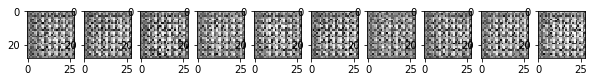

Epochs 0/10: Generator Loss: 1.893. Discriminator Loss: 0.567
Epochs 0/10: Generator Loss: 1.895. Discriminator Loss: 0.553
Epochs 0/10: Generator Loss: 1.751. Discriminator Loss: 0.609
Epochs 0/10: Generator Loss: 1.844. Discriminator Loss: 0.548
Epochs 0/10: Generator Loss: 1.999. Discriminator Loss: 0.524
Epochs 0/10: Generator Loss: 2.036. Discriminator Loss: 0.52
Epochs 0/10: Generator Loss: 1.953. Discriminator Loss: 0.801
Epochs 0/10: Generator Loss: 1.802. Discriminator Loss: 0.574
Epochs 0/10: Generator Loss: 1.88. Discriminator Loss: 0.555
Epochs 0/10: Generator Loss: 2.064. Discriminator Loss: 0.526


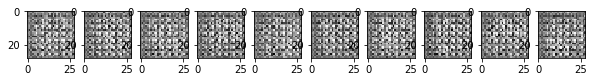

Epochs 0/10: Generator Loss: 1.864. Discriminator Loss: 0.561
Epochs 0/10: Generator Loss: 1.87. Discriminator Loss: 0.561
Epochs 0/10: Generator Loss: 1.974. Discriminator Loss: 0.542
Epochs 0/10: Generator Loss: 1.739. Discriminator Loss: 0.625
Epochs 0/10: Generator Loss: 1.844. Discriminator Loss: 0.564
Epochs 0/10: Generator Loss: 1.87. Discriminator Loss: 0.566
Epochs 0/10: Generator Loss: 1.896. Discriminator Loss: 0.595
Epochs 0/10: Generator Loss: 1.901. Discriminator Loss: 0.554
Epochs 0/10: Generator Loss: 1.964. Discriminator Loss: 0.504
Epochs 0/10: Generator Loss: 1.983. Discriminator Loss: 0.513


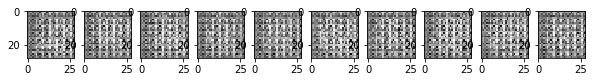

Epochs 0/10: Generator Loss: 2.118. Discriminator Loss: 0.495
Epochs 0/10: Generator Loss: 1.895. Discriminator Loss: 0.528
Epochs 0/10: Generator Loss: 1.742. Discriminator Loss: 0.664
Epochs 0/10: Generator Loss: 1.879. Discriminator Loss: 0.548
Epochs 0/10: Generator Loss: 1.599. Discriminator Loss: 0.8
Epochs 0/10: Generator Loss: 1.966. Discriminator Loss: 0.596
Epochs 0/10: Generator Loss: 1.491. Discriminator Loss: 0.656
Epochs 0/10: Generator Loss: 1.675. Discriminator Loss: 0.766
Epochs 0/10: Generator Loss: 1.643. Discriminator Loss: 0.631
Epochs 0/10: Generator Loss: 1.905. Discriminator Loss: 0.553


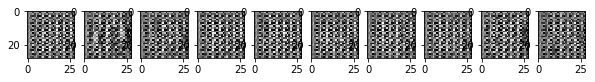

Epochs 0/10: Generator Loss: 1.9. Discriminator Loss: 0.564
Epochs 0/10: Generator Loss: 1.819. Discriminator Loss: 1.803
Epochs 0/10: Generator Loss: 1.727. Discriminator Loss: 0.562
Epochs 0/10: Generator Loss: 1.837. Discriminator Loss: 0.581
Epochs 0/10: Generator Loss: 1.815. Discriminator Loss: 0.591
Epochs 0/10: Generator Loss: 1.847. Discriminator Loss: 0.597
Epochs 0/10: Generator Loss: 1.897. Discriminator Loss: 0.593
Epochs 0/10: Generator Loss: 1.735. Discriminator Loss: 0.626
Epochs 0/10: Generator Loss: 1.817. Discriminator Loss: 0.603
Epochs 0/10: Generator Loss: 1.834. Discriminator Loss: 0.588


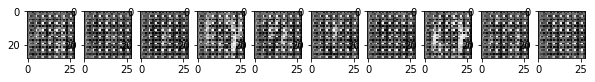

Epochs 0/10: Generator Loss: 1.794. Discriminator Loss: 0.591
Epochs 0/10: Generator Loss: 1.849. Discriminator Loss: 0.563
Epochs 0/10: Generator Loss: 1.822. Discriminator Loss: 0.633
Epochs 0/10: Generator Loss: 1.598. Discriminator Loss: 0.717
Epochs 0/10: Generator Loss: 1.73. Discriminator Loss: 0.689
Epochs 0/10: Generator Loss: 1.904. Discriminator Loss: 0.649
Epochs 0/10: Generator Loss: 1.693. Discriminator Loss: 0.744
Epochs 0/10: Generator Loss: 1.657. Discriminator Loss: 0.637
Epochs 0/10: Generator Loss: 1.666. Discriminator Loss: 0.656
Epochs 0/10: Generator Loss: 1.72. Discriminator Loss: 0.616


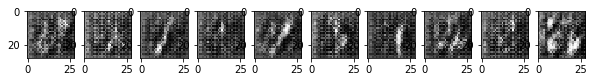

Epochs 0/10: Generator Loss: 1.726. Discriminator Loss: 0.599
Epochs 0/10: Generator Loss: 1.818. Discriminator Loss: 0.754
Epochs 0/10: Generator Loss: 1.609. Discriminator Loss: 0.648
Epochs 0/10: Generator Loss: 1.776. Discriminator Loss: 0.599
Epochs 0/10: Generator Loss: 1.589. Discriminator Loss: 0.655
Epochs 0/10: Generator Loss: 1.67. Discriminator Loss: 0.647
Epochs 0/10: Generator Loss: 1.572. Discriminator Loss: 0.669
Epochs 0/10: Generator Loss: 1.729. Discriminator Loss: 0.603
Epochs 0/10: Generator Loss: 1.645. Discriminator Loss: 0.63
Epochs 0/10: Generator Loss: 1.724. Discriminator Loss: 0.755


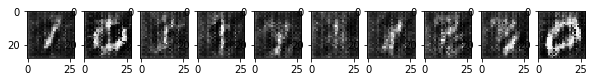

Epochs 0/10: Generator Loss: 1.758. Discriminator Loss: 0.782
Epochs 0/10: Generator Loss: 1.785. Discriminator Loss: 0.627
Epochs 0/10: Generator Loss: 1.699. Discriminator Loss: 0.65
Epochs 0/10: Generator Loss: 1.592. Discriminator Loss: 0.714
Epochs 0/10: Generator Loss: 1.812. Discriminator Loss: 0.659
Epochs 0/10: Generator Loss: 1.663. Discriminator Loss: 0.718
Epochs 0/10: Generator Loss: 1.693. Discriminator Loss: 0.654
Epochs 0/10: Generator Loss: 1.521. Discriminator Loss: 0.671
Epochs 0/10: Generator Loss: 1.731. Discriminator Loss: 0.641
Epochs 0/10: Generator Loss: 1.641. Discriminator Loss: 0.616


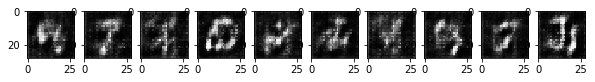

Epochs 0/10: Generator Loss: 1.951. Discriminator Loss: 0.55
Epochs 0/10: Generator Loss: 1.662. Discriminator Loss: 0.697
Epochs 0/10: Generator Loss: 1.551. Discriminator Loss: 0.66
Epochs 0/10: Generator Loss: 1.805. Discriminator Loss: 0.605
Epochs 0/10: Generator Loss: 1.759. Discriminator Loss: 0.631
Epochs 0/10: Generator Loss: 1.946. Discriminator Loss: 0.589
Epochs 0/10: Generator Loss: 1.701. Discriminator Loss: 0.627
Epochs 0/10: Generator Loss: 1.679. Discriminator Loss: 0.685
Epochs 0/10: Generator Loss: 1.716. Discriminator Loss: 0.624
Epochs 0/10: Generator Loss: 1.477. Discriminator Loss: 0.717


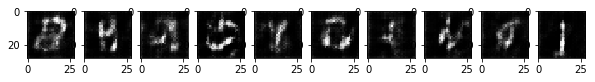

Epochs 0/10: Generator Loss: 1.737. Discriminator Loss: 0.715
Epochs 0/10: Generator Loss: 1.714. Discriminator Loss: 0.631
Epochs 0/10: Generator Loss: 1.558. Discriminator Loss: 0.707
Epochs 0/10: Generator Loss: 1.747. Discriminator Loss: 0.633
Epochs 0/10: Generator Loss: 1.689. Discriminator Loss: 0.654
Epochs 0/10: Generator Loss: 1.789. Discriminator Loss: 0.604
Epochs 0/10: Generator Loss: 1.672. Discriminator Loss: 0.655
Epochs 0/10: Generator Loss: 1.728. Discriminator Loss: 0.6
Epochs 0/10: Generator Loss: 1.84. Discriminator Loss: 0.571
Epochs 0/10: Generator Loss: 1.859. Discriminator Loss: 0.628


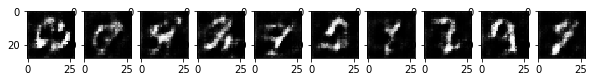

Epochs 0/10: Generator Loss: 1.75. Discriminator Loss: 0.596
Epochs 0/10: Generator Loss: 1.751. Discriminator Loss: 0.594
Epochs 0/10: Generator Loss: 1.835. Discriminator Loss: 0.621
Epochs 0/10: Generator Loss: 1.759. Discriminator Loss: 0.598
Epochs 0/10: Generator Loss: 1.622. Discriminator Loss: 0.692
Epochs 0/10: Generator Loss: 1.733. Discriminator Loss: 0.686
Epochs 0/10: Generator Loss: 1.516. Discriminator Loss: 0.683
Epochs 0/10: Generator Loss: 1.849. Discriminator Loss: 0.613
Epochs 0/10: Generator Loss: 1.707. Discriminator Loss: 0.662
Epochs 0/10: Generator Loss: 1.432. Discriminator Loss: 0.739


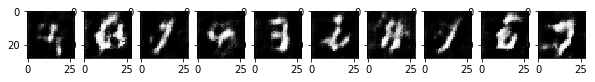

Epochs 0/10: Generator Loss: 1.573. Discriminator Loss: 0.659
Epochs 0/10: Generator Loss: 1.745. Discriminator Loss: 0.611
Epochs 0/10: Generator Loss: 1.72. Discriminator Loss: 0.643
Epochs 0/10: Generator Loss: 1.643. Discriminator Loss: 0.647
Epochs 0/10: Generator Loss: 1.792. Discriminator Loss: 0.609
Epochs 0/10: Generator Loss: 1.754. Discriminator Loss: 0.617
Epochs 0/10: Generator Loss: 1.798. Discriminator Loss: 0.666
Epochs 1/10: Generator Loss: 1.392. Discriminator Loss: 0.794
Epochs 1/10: Generator Loss: 1.532. Discriminator Loss: 0.679
Epochs 1/10: Generator Loss: 1.544. Discriminator Loss: 0.653


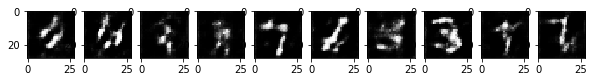

Epochs 1/10: Generator Loss: 1.692. Discriminator Loss: 0.63
Epochs 1/10: Generator Loss: 1.714. Discriminator Loss: 0.646
Epochs 1/10: Generator Loss: 1.519. Discriminator Loss: 0.657
Epochs 1/10: Generator Loss: 1.79. Discriminator Loss: 0.59
Epochs 1/10: Generator Loss: 1.723. Discriminator Loss: 0.616
Epochs 1/10: Generator Loss: 1.576. Discriminator Loss: 0.65
Epochs 1/10: Generator Loss: 1.657. Discriminator Loss: 0.662
Epochs 1/10: Generator Loss: 1.504. Discriminator Loss: 0.664
Epochs 1/10: Generator Loss: 1.673. Discriminator Loss: 0.655
Epochs 1/10: Generator Loss: 1.663. Discriminator Loss: 0.633


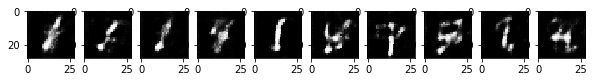

Epochs 1/10: Generator Loss: 1.846. Discriminator Loss: 0.613
Epochs 1/10: Generator Loss: 1.947. Discriminator Loss: 0.564
Epochs 1/10: Generator Loss: 1.833. Discriminator Loss: 0.596
Epochs 1/10: Generator Loss: 1.748. Discriminator Loss: 0.622
Epochs 1/10: Generator Loss: 1.783. Discriminator Loss: 0.638
Epochs 1/10: Generator Loss: 1.702. Discriminator Loss: 0.627
Epochs 1/10: Generator Loss: 1.701. Discriminator Loss: 0.644
Epochs 1/10: Generator Loss: 1.762. Discriminator Loss: 0.598
Epochs 1/10: Generator Loss: 1.727. Discriminator Loss: 0.639
Epochs 1/10: Generator Loss: 1.62. Discriminator Loss: 0.675


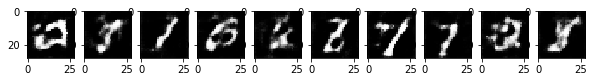

Epochs 1/10: Generator Loss: 1.835. Discriminator Loss: 0.637
Epochs 1/10: Generator Loss: 1.74. Discriminator Loss: 0.675
Epochs 1/10: Generator Loss: 1.541. Discriminator Loss: 0.653
Epochs 1/10: Generator Loss: 1.636. Discriminator Loss: 0.632
Epochs 1/10: Generator Loss: 1.846. Discriminator Loss: 0.582
Epochs 1/10: Generator Loss: 1.743. Discriminator Loss: 0.736
Epochs 1/10: Generator Loss: 1.502. Discriminator Loss: 0.687
Epochs 1/10: Generator Loss: 1.922. Discriminator Loss: 0.589
Epochs 1/10: Generator Loss: 1.777. Discriminator Loss: 0.586
Epochs 1/10: Generator Loss: 1.873. Discriminator Loss: 0.615


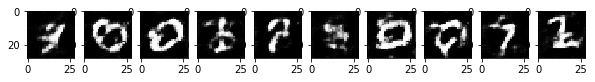

Epochs 1/10: Generator Loss: 1.748. Discriminator Loss: 0.618
Epochs 1/10: Generator Loss: 1.803. Discriminator Loss: 0.66
Epochs 1/10: Generator Loss: 1.763. Discriminator Loss: 0.59
Epochs 1/10: Generator Loss: 1.861. Discriminator Loss: 0.595
Epochs 1/10: Generator Loss: 2.024. Discriminator Loss: 0.595
Epochs 1/10: Generator Loss: 1.808. Discriminator Loss: 0.63
Epochs 1/10: Generator Loss: 1.801. Discriminator Loss: 0.577
Epochs 1/10: Generator Loss: 1.782. Discriminator Loss: 0.596
Epochs 1/10: Generator Loss: 1.899. Discriminator Loss: 0.634
Epochs 1/10: Generator Loss: 1.746. Discriminator Loss: 0.619


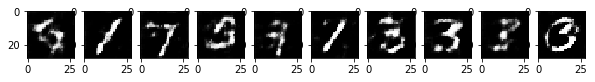

Epochs 1/10: Generator Loss: 1.811. Discriminator Loss: 0.59
Epochs 1/10: Generator Loss: 1.93. Discriminator Loss: 0.66
Epochs 1/10: Generator Loss: 1.68. Discriminator Loss: 0.656
Epochs 1/10: Generator Loss: 1.81. Discriminator Loss: 0.745
Epochs 1/10: Generator Loss: 1.943. Discriminator Loss: 0.675
Epochs 1/10: Generator Loss: 1.733. Discriminator Loss: 0.652
Epochs 1/10: Generator Loss: 1.62. Discriminator Loss: 0.722
Epochs 1/10: Generator Loss: 1.872. Discriminator Loss: 0.599
Epochs 1/10: Generator Loss: 1.847. Discriminator Loss: 0.58
Epochs 1/10: Generator Loss: 1.693. Discriminator Loss: 0.663


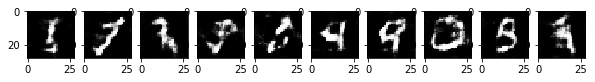

Epochs 1/10: Generator Loss: 1.978. Discriminator Loss: 0.579
Epochs 1/10: Generator Loss: 1.843. Discriminator Loss: 0.594
Epochs 1/10: Generator Loss: 1.78. Discriminator Loss: 0.657
Epochs 1/10: Generator Loss: 1.894. Discriminator Loss: 0.728
Epochs 1/10: Generator Loss: 1.946. Discriminator Loss: 0.619
Epochs 1/10: Generator Loss: 1.759. Discriminator Loss: 0.629
Epochs 1/10: Generator Loss: 1.616. Discriminator Loss: 0.664
Epochs 1/10: Generator Loss: 1.737. Discriminator Loss: 0.63
Epochs 1/10: Generator Loss: 1.863. Discriminator Loss: 0.601
Epochs 1/10: Generator Loss: 1.701. Discriminator Loss: 0.655


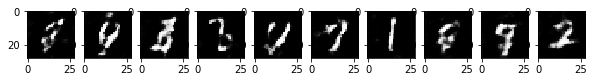

Epochs 1/10: Generator Loss: 1.842. Discriminator Loss: 0.6
Epochs 1/10: Generator Loss: 1.82. Discriminator Loss: 0.621
Epochs 1/10: Generator Loss: 1.784. Discriminator Loss: 0.614
Epochs 1/10: Generator Loss: 1.876. Discriminator Loss: 0.589
Epochs 1/10: Generator Loss: 1.867. Discriminator Loss: 0.634
Epochs 1/10: Generator Loss: 1.876. Discriminator Loss: 0.653
Epochs 1/10: Generator Loss: 1.954. Discriminator Loss: 0.612
Epochs 1/10: Generator Loss: 2.004. Discriminator Loss: 0.608
Epochs 1/10: Generator Loss: 1.778. Discriminator Loss: 0.634


KeyboardInterrupt: 

In [13]:
projection_data_path = '/Users/adalbertoclaudioquiros/Documents/Code/UofG/PhD/GANs'
dataset = Dataset(train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=True)

epochs = 10
batch_size = 32
z_dim = 100
learning_rate = 1e-4
beta1 = 0.5
image_type = 'gray'
alpha = 0.2

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, dataset, image_type, alpha)